Classify handwritten digits 

Architecture 

Input <-- CNN_1_BatchNorm_ReLU (8 feature maps) <-- MaxPool (8 feature maps) <-- CNN_2_BatchNorm_ReLU (32 fearture maps) <-- MaxPool (32 feature maps) <-- FC1 (600 neurons) <--FC2 (10 classes/output)

In [47]:
import torch 
import torch.nn as nn 
import torchvision.transforms as transforms 
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt 
from torch.autograd import Variable
import cv2
from PIL import Image

In [48]:
#Mean and Std of the MNIST dataset - Used for image normalisation
mean_gray = 0.1307
std_gray = 0.3081 

#Transform the image to tensor and normalise the image
#Since this is a grey scale image there is only 1 channel (RGB will have 3 channels)
# input[channel] = (input[channel] - mean[channel]) / std[channel]

transformation = transforms.Compose([transforms.ToTensor(), 
                                 transforms.Normalize((mean_gray,), (std_gray,))]) 
#To transform your own handwritten Image
transform_photo = transforms.Compose([transforms.Resize((28,28)),
                                      transforms.ToTensor(), 
                                      transforms.Normalize((mean_gray,), (std_gray,))])

train_dataset = datasets.MNIST(root="./data", 
                               train=True, 
                               transform=transformation, 
                               download=True)

test_dataset = datasets.MNIST(root="./data", 
                              train=False, 
                              transform=transformation,
                              download=True)

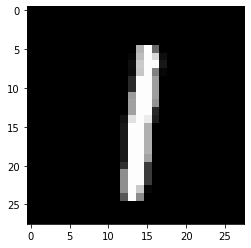

In [29]:
import matplotlib.pyplot as plt 
random_img = train_dataset[40][0].numpy() * std_gray + mean_gray #Each image has input and label 
plt.imshow(random_img.reshape(28,28), cmap="gray")

In [30]:
print(train_dataset[40][1])

1


In [31]:
batch_size = 100

train_load = torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True)

test_load = torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=batch_size,
                                        shuffle=False)

In [32]:
len(train_load) #60000/100

600

In [33]:
len(train_dataset)

60000

In [34]:
len(test_load)

100

In [35]:
len(test_dataset)

10000

In [36]:
# Build the CNN 
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        #CNN 1 (Check the markdown at the start)
        #Same padding means ip size == op size
        #Padding = (filter_size-1)/2
        self.CNN1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size= 3, stride = 1, padding = 1) #in_channels = 1 as grey scale image have 1 channel
        #Output size of each of 8 feature map = [Input size  - Filter size + 2(Padding)/Stride + 1] = (28 - 3 + 2 + 1) = 28

        #Batch normalisation
        self.batchnorm1 = nn.BatchNorm2d(num_features=8) #As we are getting 8 outputs

        #Activation function
        self.relu = nn.ReLU()

        #Max Pool
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        #Output size of Maxpool = 28/2 = 14 (kernal_size = 2)

        #CNN 2
        self.CNN2 = nn.Conv2d(in_channels = 8, out_channels = 32, kernel_size = 5,stride = 1, padding = 2) # in_channel = 8 as the out_channel for previous CNN is 8 
        #Output size of each of 32 feature map = [Input size  - Filter size + 2(Padding)/Stride + 1] = (14 - 5 + 4 + 1) = 14

        #Batch normalisation
        self.batchnorm2 = nn.BatchNorm2d(num_features=32) #As we are getting 32 outputs
        #self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        #Output size of Maxpool = 14/2 = 7

        #Flatten the 32 feature maps = 7*7*32 = 1568

        #Linear layers
        self.fc1 = nn.Linear(in_features=1568, out_features=600)

        self.dropout = nn.Dropout(p=0.5) #Drop neurons by 50%

        self.fc2 = nn.Linear(in_features=600, out_features=10)

    def forward(self, x):
        out = self.CNN1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.CNN2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        #Flatten the 32 feature maps from Max pooling to feed to FC Layer(100, 1568)
        out = out.view(-1,1568)   

        #Forward through FC layer
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

In [37]:
torch.cuda.is_available() #No GPU on this machine

False

In [38]:
model = CNN()

In [39]:
#Define loss Cross Entropy Loss
loss_function = nn.CrossEntropyLoss()

In [40]:
#Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [41]:
#Train the CNN
num_epochs = 5 
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    correct = 0 
    iteration = 0 
    iter_loss = 0.0 #loss for one iteration 

    model.train() #Put the model in training mode

    for i,(inputs,labels) in enumerate(train_load):

        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)

                
        outputs = model(inputs)
        loss = loss_function(outputs, labels) #loss between prediction and actual
        iter_loss += loss.item() #The loss will be in tensor and .item() extracts the value from tensor 
        optimizer.zero_grad() #Clear the gradiants w = w - lr*gradients (Clear the gradients)

        #Back prop
        loss.backward()

        #Update the weights
        optimizer.step()

        _, predicted = torch.max(outputs, 1) #For 1st dimension  (_ ignores the value (Ignore max value and take only index))

        correct += (predicted == labels).sum().item()

        iteration += 1

    train_loss.append(iter_loss / iteration) 
    train_accuracy.append(100 * correct / len(train_dataset)) #Correct / 60,000 (Accuracy)

    #Testing Phase
    testing_loss = 0.0
    correct = 0 
    iteration = 0

    model.eval() # Put the network into evaluation mode

    for i,(inputs,labels) in enumerate(test_load):

        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)

        outputs = model(inputs)
        loss = loss_function(outputs, labels) 
        testing_loss += loss.item() 

        #No backprop in testing the model

        _, predicted = torch.max(outputs, 1) #For 1st dimension  (_ ignores the value (Ignore max value and take only index))
        correct += (predicted == labels).sum().item()
        iteration += 1

    test_loss.append(testing_loss / iteration) 
    test_accuracy.append(100 *correct / len(test_dataset)) #Correct / 60,000 (Accuracy)


    print(f'Epoch: {epoch+1}/{num_epochs}')
    print(f"Training loss: {train_loss[-1]}, Training Accuracy: {train_accuracy[-1]}") #Get the last values for loss and accuracy
    print(f"Test loss: {test_loss[-1]}, Test Accuracy: {test_accuracy[-1]}") #Get the last values for loss and accuracy

Epoch: 1/5
Training loss: 0.48971453099201123, Training Accuracy: 87.045
Test loss: 0.14781152645125986, Test Accuracy: 96.01
Epoch: 2/5
Training loss: 0.15196772765368224, Training Accuracy: 95.565
Test loss: 0.08901144624687732, Test Accuracy: 97.3
Epoch: 3/5
Training loss: 0.11061025516750912, Training Accuracy: 96.855
Test loss: 0.07116517153335736, Test Accuracy: 97.81
Epoch: 4/5
Training loss: 0.09061242957909901, Training Accuracy: 97.335
Test loss: 0.060534108513966206, Test Accuracy: 98.08
Epoch: 5/5
Training loss: 0.08034670648941149, Training Accuracy: 97.64166666666667
Test loss: 0.05359207517467439, Test Accuracy: 98.32


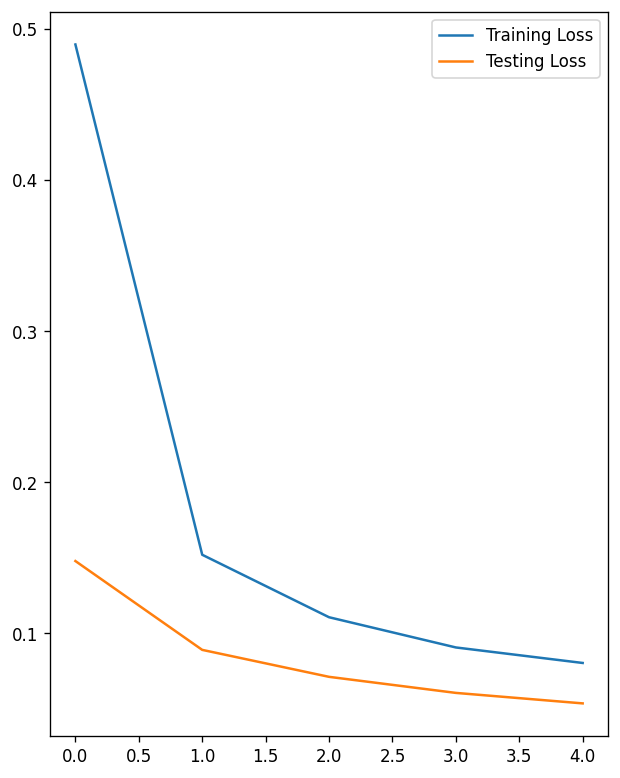

In [42]:
#Plotting the loss 
plt.figure(dpi=120, figsize=(6,8))
plt.plot(train_loss, label = "Training Loss")
plt.plot(test_loss, label = "Testing Loss")
plt.legend()

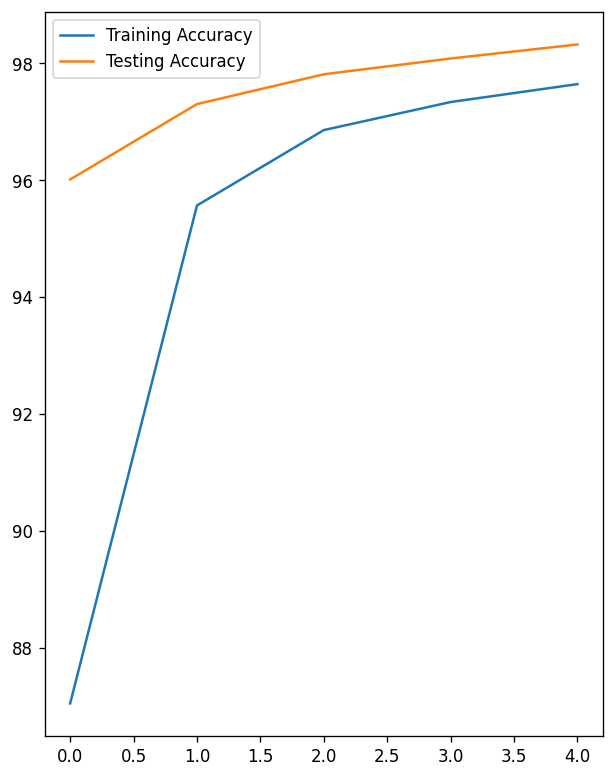

In [43]:
#Plotting the accuracy
plt.figure(dpi=120, figsize=(6,8))
plt.plot(train_accuracy, label = "Training Accuracy")
plt.plot(test_accuracy, label = "Testing Accuracy")
plt.legend()

In [46]:
img = test_dataset[35][0].resize_((1,1,28,28))# Need to reshape the image to (28, 28)
label = test_dataset[35][1]

model.eval()

outputs = model(img)
_, predicted = torch.max(outputs, 1)
print(f'Prediction is: f{predicted.item()}')
print(f'Actual is: {label}')

Prediction is: f2
Actual is: 2


In [49]:
def predict(img_name, model):
    image = cv2.imread(img_name,0) #read the image (0 to transform to grey scale)
    ret, thresholded = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY) #127 is threshold value with max 255
    img = 255 - thresholded
    cv2.imshow("Original", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    img = Image.fromarray(img)
    img = transform_photo(img) #Transfrom the image
    img = img.view(1,1,28,28)
    img = Variable(img)

    model.eval()

    output = model(img)
    print(output)
    print(output.data)
    _, predicted = torch.max(output,1)

    return predicted.item()

In [55]:
pred = predict("image.jpg", model)
print(f"The predicted label is {pred}")

tensor([[-1.4660,  0.7128,  2.8722,  3.4576, -3.9227, -0.7441, -3.6369,  4.7999,
         -0.2151,  0.3393]], grad_fn=<AddmmBackward0>)
tensor([[-1.4660,  0.7128,  2.8722,  3.4576, -3.9227, -0.7441, -3.6369,  4.7999,
         -0.2151,  0.3393]])
The predicted label is 7
